In [1]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet, S2ConvNet
from data_loader import load_test_data
from foolbox import PyTorchModel
from attacks import LinfRandomSearch
from tqdm.notebook import tqdm
from attack_helper import batched_predictions
from mlflow.tracking.artifact_utils import get_artifact_uri

In [2]:
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(1668361949)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
model = ConvNet(hparams, None, None).eval()
model.load_state_dict(best_model['state_dict'])


S2run_id=df[df['tags.mlflow.runName']==str(1668559990)]['run_id'].values[0]
S2artifact_path = get_artifact_uri(run_id=S2run_id, tracking_uri=tracking_uri)
S2dirs=os.listdir(S2artifact_path)

for s in S2dirs:
    if s.find('.ckpt') >= 0:
        S2checkpoint = s
        break

S2checkpoint_path = os.path.join(S2artifact_path, S2checkpoint)

S2best_model = torch.load(S2checkpoint_path)
S2hparams = argparse.Namespace(**S2best_model['hyper_parameters'])
S2model = S2ConvNet(S2hparams, None, None).eval()
S2model.load_state_dict(S2best_model['state_dict'])


TEST_PATH = "s2_mnist_cs1.gz"
test_data = load_test_data(TEST_PATH)

In [50]:
images_ = test_data[:][0]
labels_ = test_data[:][1]

images = images_[labels_ == 0][:10]
for i in range(1,10):
    images = torch.cat((images, images_[labels_ == i][:10]))
    
labels = labels_[labels_ == 0][:10]
for i in range(1,10):
    labels = torch.cat((labels, labels_[labels_ == i][:10]))

fmodel = PyTorchModel(model, bounds=(0, 255))

In [51]:
bs = 100

clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
epsilons = [0, 0.1, 0.25, 0.5, 1, 3, 5, 7.5, 10, 20, 50, 100]
attack = LinfRandomSearch()

In [52]:
success = []
advs = []
preds = []
for i in tqdm(range(50)):
    _, advs_, success_ = attack(fmodel, ep.astensor(images.cuda()), ep.astensor(clean_pred.cuda()), epsilons=epsilons)
    success.append(success_.raw.cpu())
    dummy = torch.stack([advs_[i].raw.detach().cpu() for i in range(len(advs_))])
    advs.append(dummy)
    preds.append(torch.stack([torch.max(model(advs_[i].raw),1)[1].detach().cpu() for i in range(len(advs_))]))
    
success = torch.stack(success).permute(1,2,0)
advs = torch.stack(advs).permute(1,2,3,4,5,0)
preds = torch.stack(preds).permute(1,2,0)

  0%|          | 0/50 [00:00<?, ?it/s]

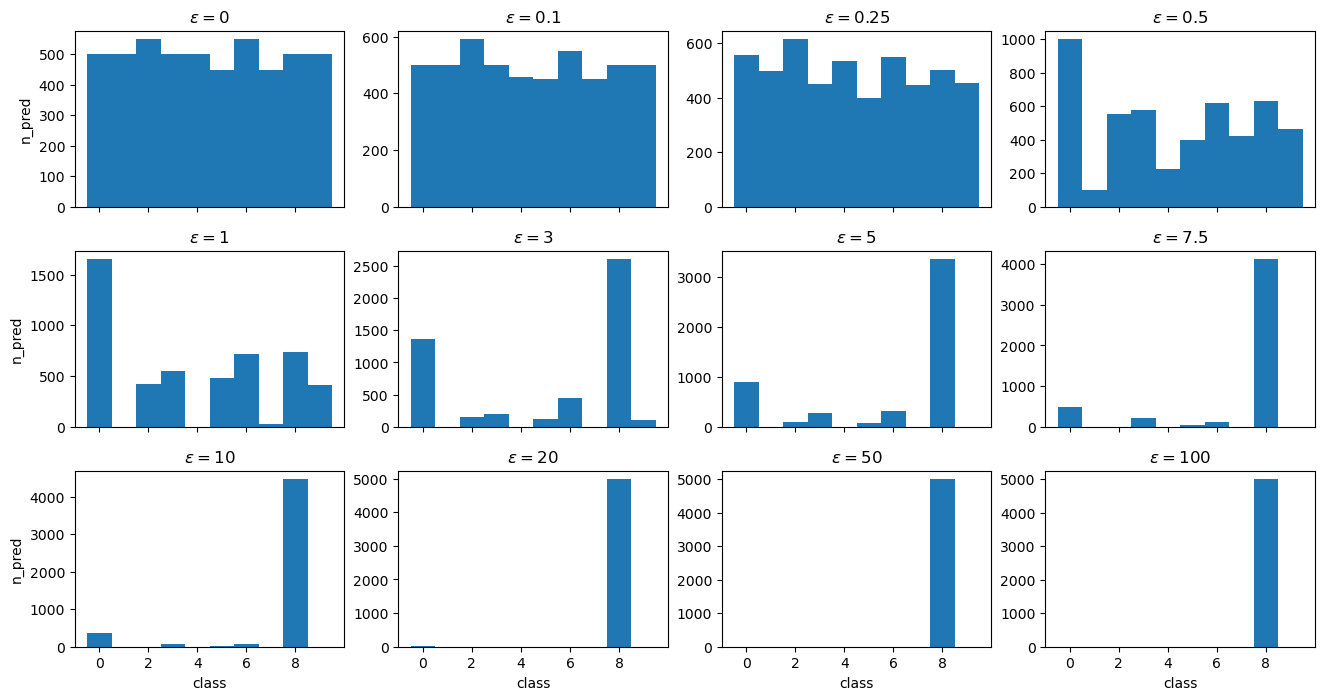

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (16, 8), sharex=True, gridspec_kw={'wspace':0.2, 'hspace':0.25})

for i in range(12):
    axs[i//4,i%4].hist(preds[i].flatten(), bins=10, range=(-0.5,9.5))
    axs[i//4,i%4].set_title(f'$\epsilon = {epsilons[i]}$')
    
for j in range(4):
    axs[2,j].set_xlabel('class')
    axs[2,j].set_xticks(torch.arange(0,9,2))
    
for k in range(3):
    axs[k,0].set_ylabel('n_pred')
    
# plt.savefig('random_search_bl10_pred_inspection.pdf', bbox_inches="tight")
    
plt.show()

In [ ]:
success_per_sample = torch.amax(ep.astensor(success).float32().raw, dim=-1)

In [ ]:
success_rate = torch.mean(success_per_sample, dim=-1)
print(success_rate)

In [ ]:
plt.plot(epsilons, success_rate, 'o-')
plt.xlabel('$\epsilon$')
plt.ylabel('success rate')
plt.show()

In [7]:
S2fmodel = PyTorchModel(S2model, bounds=(0, 255))

S2clean_pred = batched_predictions(S2model, images, bs)

  0%|          | 0/1 [00:00<?, ?it/s]

load 0.pkl.gz... done
load 0.pkl.gz... done
load 1.pkl.gz... done
load 21.pkl.gz... done
load 18.pkl.gz... done
load 15.pkl.gz... done
load 22.pkl.gz... done
load 17.pkl.gz... done
load 20.pkl.gz... done


In [8]:
S2success = []
S2advs = []
S2preds = []
for i in tqdm(range(50)):
    _, S2advs_, S2success_ = attack(S2fmodel, ep.astensor(images.cuda()), ep.astensor(S2clean_pred.cuda()), epsilons=epsilons)
    S2success.append(S2success_.raw.cpu())
    S2dummy = torch.stack([S2advs_[i].raw.detach().cpu() for i in range(len(S2advs_))])
    S2advs.append(S2dummy)
    S2preds.append(torch.stack([torch.max(S2model(S2advs_[i].raw),1)[1].detach().cpu() for i in range(len(S2advs_))]))
    
S2success = torch.stack(S2success).permute(1,2,0)
S2advs = torch.stack(S2advs).permute(1,2,3,4,5,0)
S2preds = torch.stack(S2preds).permute(1,2,0)

  0%|          | 0/50 [00:00<?, ?it/s]

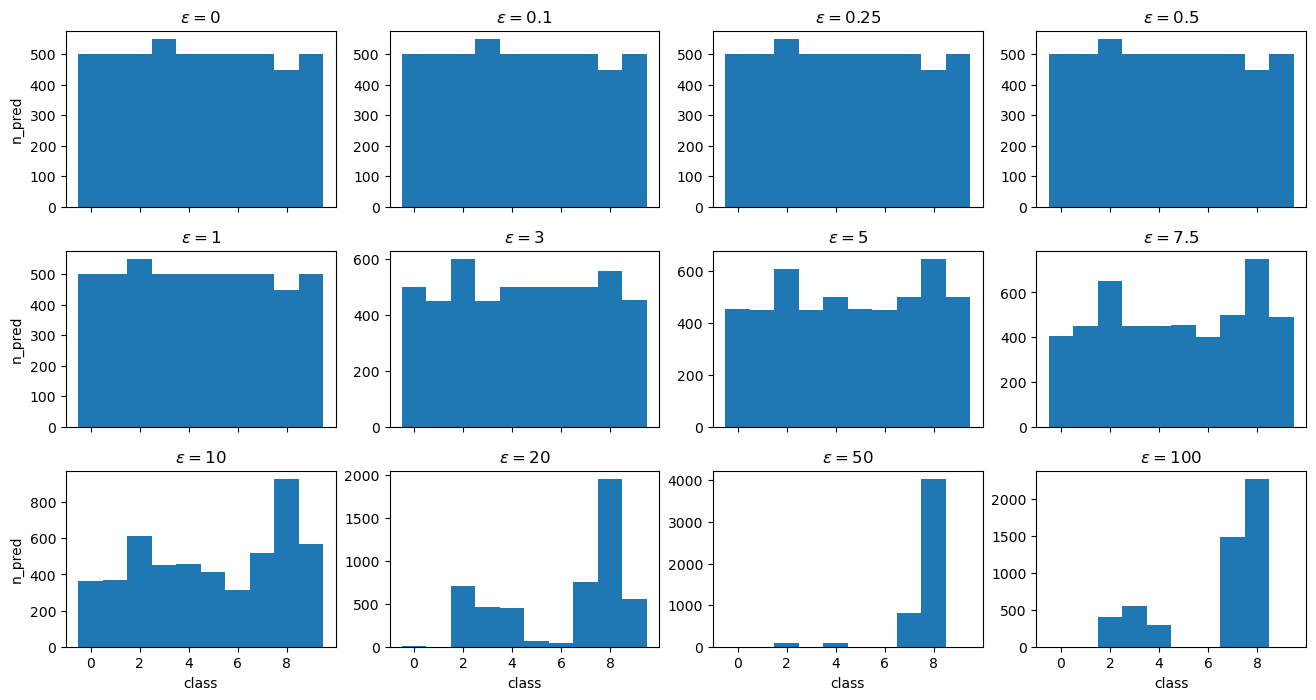

In [45]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (16, 8), sharex=True, gridspec_kw={'wspace':0.2, 'hspace':0.25})

for i in range(12):
    axs[i//4,i%4].hist(S2preds[i].flatten(), bins=10, range=(-0.5,9.5))
    axs[i//4,i%4].set_title(f'$\epsilon = {epsilons[i]}$')
    
for j in range(4):
    axs[2,j].set_xlabel('class')
    axs[2,j].set_xticks(torch.arange(0,9,2))
    
for k in range(3):
    axs[k,0].set_ylabel('n_pred')
    
# plt.savefig('random_search_S2CNN0_pred_inspection.pdf', bbox_inches="tight")
    
plt.show()

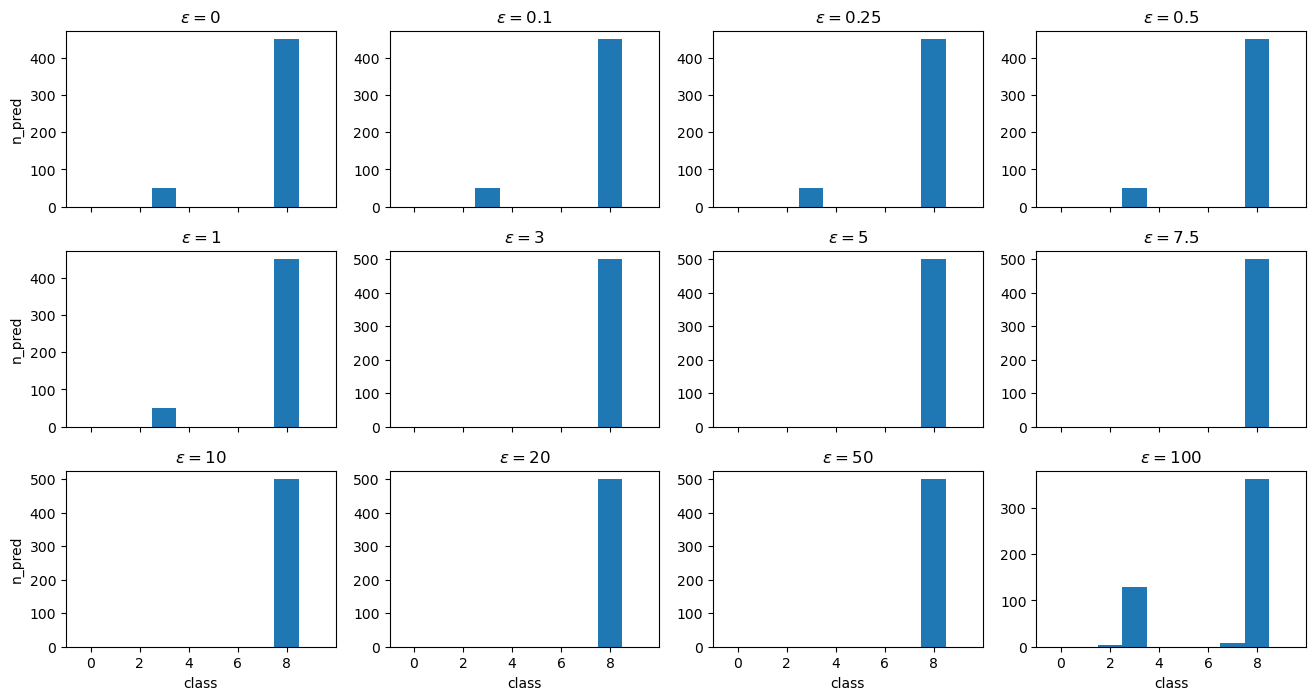

In [46]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (16, 8), sharex=True, gridspec_kw={'wspace':0.2, 'hspace':0.25})

for i in range(12):
    axs[i//4,i%4].hist(S2preds[i][80:90].flatten(), bins=10, range=(-0.5,9.5))
    axs[i//4,i%4].set_title(f'$\epsilon = {epsilons[i]}$')
    
for j in range(4):
    axs[2,j].set_xlabel('class')
    axs[2,j].set_xticks(torch.arange(0,9,2))
    
for k in range(3):
    axs[k,0].set_ylabel('n_pred')
    
# plt.savefig('random_search_S2CNN0_only8_pred_inspection.pdf', bbox_inches="tight")
    
plt.show()

In [28]:
S2clean_pred[80:90]

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 3])

In [44]:
for i in range(10):
    print(S2clean_pred[10*i:10*(i+1)])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 3])
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9])


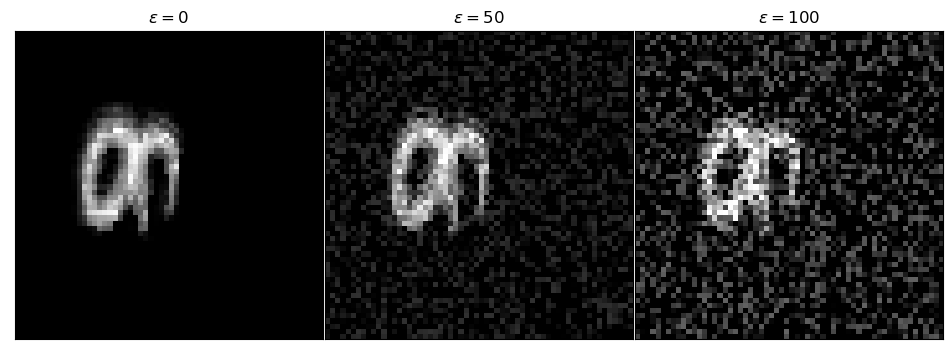

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (12, 4), gridspec_kw={'wspace':0, 'hspace':0.5})

axs[0].imshow(images[89,0], cmap='gray')
axs[0].set_title(f'$\epsilon = {epsilons[0]}$')
axs[1].imshow(S2advs[10,89,0,:,:,0], cmap='gray')
axs[1].set_title(f'$\epsilon = {epsilons[10]}$')
axs[2].imshow(S2advs[11,89,0,:,:,0], cmap='gray')
axs[2].set_title(f'$\epsilon = {epsilons[11]}$')

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# plt.savefig('random_search_S2CNN0_wrong8_pred_inspection.pdf', bbox_inches="tight")

plt.show()

In [56]:
success.size()

torch.Size([12, 100, 50])